# Instaling  packages

In [1]:
# Stable Baselines only supports tensorflow 1.x for now
%tensorflow_version 1.x
!apt-get install ffmpeg freeglut3-dev xvfb  # For visualization
!apt install swig cmake libopenmpi-dev zlib1g-dev
!pip install stable-baselines[mpi]==2.10.2 box2d box2d-kengz


TensorFlow 1.x selected.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
freeglut3-dev is already the newest version (2.8.1-3).
freeglut3-dev set to manually installed.
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
The following NEW packages will be installed:
  xvfb
0 upgraded, 1 newly installed, 0 to remove and 39 not upgraded.
Need to get 784 kB of archives.
After this operation, 2,270 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.9 [784 kB]
Fetched 784 kB in 1s (1,040 kB/s)
Selecting previously unselected package xvfb.
(Reading database ... 160772 files and directories currently installed.)
Preparing to unpack .../xvfb_2%3a1.19.6-1ubuntu4.9_amd64.deb ...
Unpacking xvfb (2:1.19.6-1ubuntu4.9) ...
Setting up xvfb (2:1.19.6-1ubuntu4.9) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Reading package lists... Done
Building de

# Importing Libraries

In [2]:
import stable_baselines
import os
import matplotlib.pyplot as plt
import gym
import numpy as np
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines import TRPO , DQN, ACER, ACKTR
from stable_baselines.ddpg.policies import LnMlpPolicy
from stable_baselines.bench import Monitor
from stable_baselines.results_plotter import load_results, ts2xy
from stable_baselines.common.noise import AdaptiveParamNoiseSpec, NormalActionNoise
from stable_baselines.common.callbacks import BaseCallback
from stable_baselines.common.evaluation import evaluate_policy
from stable_baselines.common.callbacks import CheckpointCallback
from stable_baselines.common.vec_env import VecVideoRecorder, DummyVecEnv
from stable_baselines.common.policies import MlpPolicy

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



/usr/local/lib/python3.7/dist-packages/stable_baselines/__init__.py:33: UserWarning: stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation.
  "stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation."


# 1. Exploring 'LunarLander-v2' Environmnet Before Training

In [3]:
env = gym.make('LunarLander-v2') # generating environment

model = TRPO('MlpPolicy', env, verbose=0)





Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.












# Evaluate Model before training

In [4]:
def evaluate(model, num_episode = 100):
  for ep in range(1, num_episode + 1): # run through episodes
    done = False
    total_reward = 0
    obs = env.reset()

    while not done:
      action, _state = model.predict(obs)
      obs, reward, done, info =env.step(action)

      total_reward += reward
      if done == True:
        print(f'Episode {ep} Average reward: {np.mean(total_reward)}')
  env.close()
  return


In [5]:
evaluate(model, 20)

Episode 1 Average reward: -142.4219308974964
Episode 2 Average reward: -202.67566932644476
Episode 3 Average reward: -142.42787325806785
Episode 4 Average reward: -222.70998551973594
Episode 5 Average reward: -262.90984450855944
Episode 6 Average reward: -202.8190044249905
Episode 7 Average reward: -262.589336189639
Episode 8 Average reward: -102.99014209100395
Episode 9 Average reward: -149.96420030334866
Episode 10 Average reward: -12.546659508918182
Episode 11 Average reward: -189.40268483764748
Episode 12 Average reward: -94.69133333532149
Episode 13 Average reward: -221.15180960423567
Episode 14 Average reward: -283.9442614406282
Episode 15 Average reward: -101.90516827754668
Episode 16 Average reward: -110.0273181005843
Episode 17 Average reward: -256.6314882975921
Episode 18 Average reward: -216.52693425653388
Episode 19 Average reward: -89.06140939011512
Episode 20 Average reward: -133.99911129107448


# Visualizing LunarLander-v2 Before training

In [6]:
# Set up fake display; otherwise rendering will fail
import os
os.system("Xvfb :1 -screen 0 1024x768x24 &")
os.environ['DISPLAY'] = ':1'

In [7]:
import base64
from pathlib import Path

from IPython import display as ipythondisplay

def show_videos(video_path='', prefix=''):
  """
  Taken from https://github.com/eleurent/highway-env

  :param video_path: (str) Path to the folder containing videos
  :param prefix: (str) Filter the video, showing only the only starting with this prefix
  """
  html = []
  for mp4 in Path(video_path).glob("{}*.mp4".format(prefix)):
      video_b64 = base64.b64encode(mp4.read_bytes())
      html.append('''<video alt="{}" autoplay 
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{}" type="video/mp4" />
                </video>'''.format(mp4, video_b64.decode('ascii')))
  ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))
  return

In [8]:


def record_video(env_id, model, video_length=500, prefix='', video_folder='videos/'):
  """
  :param env_id: (str)
  :param model: (RL model)
  :param video_length: (int)
  :param prefix: (str)
  :param video_folder: (str)
  """
  eval_env = DummyVecEnv([lambda: gym.make(env_id)])
  # Start the video at step=0 and record 500 steps
  obs = eval_env.reset()
  eval_env = VecVideoRecorder(eval_env, video_folder=video_folder,
                              record_video_trigger=lambda step: step == 0, video_length=video_length,
                              name_prefix=prefix)

  eval_env.reset()
  for _ in range(video_length + 1):
    action, _ = model.predict(obs)
    obs, _, _, _ = eval_env.step(action)

  # Close the video recorder
  eval_env.close()
  return

In [9]:
record_video('LunarLander-v2', model, video_length=1500, prefix='before_trpo-Lunar')

Saving video to  /content/videos/before_trpo-Lunar-step-0-to-step-1500.mp4


In [10]:
show_videos('videos', prefix='before')

In [11]:
env.close()

# Define Callback function that saves best model 

In [12]:
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """
    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super(SaveOnBestTrainingRewardCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, 'best_model')
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

          # Retrieve training reward
          x, y = ts2xy(load_results(self.log_dir), 'timesteps')
          if len(x) > 0:
              # Mean training reward over the last 100 episodes
              mean_reward = np.mean(y[-100:])
              if self.verbose > 0:
                print("Num timesteps: {}".format(self.num_timesteps))
                print("Best mean reward: {:.2f} - Last mean reward per episode: {:.2f}".format(self.best_mean_reward, mean_reward))

              # New best model, you could save the agent here
              if mean_reward > self.best_mean_reward:
                  self.best_mean_reward = mean_reward
                  # Example for saving best model
                  if self.verbose > 0:
                    print("Saving new best model to {}".format(self.save_path))
                  self.model.save(self.save_path)

        return True

In [13]:
# Create log dir
log_dir_list = []
log_dir = "/tmp/gym/tpro"
log_dir_list.append(log_dir)
os.makedirs(log_dir, exist_ok=True)

# Create and wrap the environment
env = gym.make('LunarLander-v2')  
# Logs will be saved in log_dir/monitor.csv
env = Monitor(env, log_dir)
env = DummyVecEnv([lambda: env])


#Build Nueral network 

In [14]:
from stable_baselines.common.policies import FeedForwardPolicy, register_policy

In [15]:
# Custom MLP policy of three layers of size 128 each
class CustomPolicy(FeedForwardPolicy):
    def __init__(self, *args, **kwargs):
        super(CustomPolicy, self).__init__(*args, **kwargs,
                                           net_arch=[dict(pi=[128, 128, 128,4],
                                                          vf=[128, 128, 128,128])],
                                           feature_extraction="mlp")
register_policy('CustomPolicy', CustomPolicy)

In [16]:
# Create the callback: check every 1000 steps
model_trpo = TRPO('CustomPolicy', env, verbose=0)
callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)
# Train the agent
model_trpo.learn(total_timesteps=int(50000), callback = callback)

Num timesteps: 0
Best mean reward: -inf - Last mean reward per episode: -150.93
Saving new best model to /tmp/gym/tpro/best_model

Num timesteps: 1024
Best mean reward: -150.93 - Last mean reward per episode: -134.79
Saving new best model to /tmp/gym/tpro/best_model
Num timesteps: 2048
Best mean reward: -134.79 - Last mean reward per episode: -135.92
Num timesteps: 3072
Best mean reward: -134.79 - Last mean reward per episode: -126.43
Saving new best model to /tmp/gym/tpro/best_model
Num timesteps: 4096
Best mean reward: -126.43 - Last mean reward per episode: -118.81
Saving new best model to /tmp/gym/tpro/best_model
Num timesteps: 5120
Best mean reward: -118.81 - Last mean reward per episode: -125.42
Num timesteps: 6144
Best mean reward: -118.81 - Last mean reward per episode: -119.53
Num timesteps: 7168
Best mean reward: -118.81 - Last mean reward per episode: -114.29
Saving new best model to /tmp/gym/tpro/best_model
Num timesteps: 8192
Best mean reward: -114.29 - Last mean reward pe

# Visualizing LunarLanderContinuous-v2 after training using TRPO

In [17]:
record_video('LunarLander-v2', model, video_length=1000, prefix='after_trpo-luner')

Saving video to  /content/videos/after_trpo-luner-step-0-to-step-1000.mp4


In [18]:
show_videos('videos', prefix='after')

In [19]:
env.close()

# Ploting Learning curve

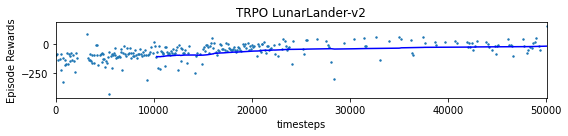

In [20]:
from stable_baselines import results_plotter

# Helper from the library
results_plotter.plot_results([log_dir], 1e5, results_plotter.X_TIMESTEPS, "TRPO LunarLander-v2")

In [21]:
def moving_average(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, 'valid')


def plot_results(log_folder =[],algorithms = [], title='Learning Curve'):
    """
    plot the results

    :param log_folder: (str) the save location of the results to plot
    :param title: (str) the title of the task to plot
    """
    x_list = []
    y_list = []
    for one_log in log_folder:
      x, y = ts2xy(load_results(one_log), 'timesteps')
      y = moving_average(y, window=50)
      x = x[len(x) - len(y):]
      x_list.append(x)
      y_list.append(y)

    fig = plt.figure(title)
    for x, y, alg in zip(x_list, y_list, algorithms):
      plt.plot(x, y, label = alg)
    
    
    plt.xlabel('Number of Timesteps')
    plt.ylabel('Rewards')
    plt.title(title + " Smoothed")
    plt.legend()
    plt.show()


#ACKTR Algorithm on LunarLander-v2

In [22]:
env = gym.make('LunarLander-v2')

log_dir = '/tmp/gym/acktr'
os.makedirs(log_dir, exist_ok=True)

#log_dir_list.append(log_dir)
                    
env = Monitor(env,log_dir)
env = DummyVecEnv([lambda: env])
callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)
model_acktr = ACKTR('CustomPolicy', env, verbose = 1)
model_acktr.learn(total_timesteps=50000, callback= callback)




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where








-----------------------------------------
| EpLenMean               | 341         |
| EpRewMean               | -4.95       |
| EpThisIter              | 3           |
| EpisodesSoFar           | 276         |
| TimeElapsed             | 135         |
| TimestepsSoFar          | 50176       |
| entloss                 | 0.0         |
| entropy                 | 0.7623957   |
| explained_variance      | 0.00754     |
| explained_variance_t... | 0.178       |
| fps                     | 17          |
| meankl                  | 0.010128947 |
| nupdates                | 1           |
| optimgain               | 0.034621533 |
| policy_entropy          | 1.39        |
| policy_loss             | 11.9        |
| surrgain                | 0.034621533 |
| total_timesteps         | 20          |
| value_loss              | 78.8        |
-----------------------------------------
Num timesteps: 

In [23]:
env.close()

# Training on DQN

In [24]:
env = gym.make('LunarLander-v2')

log_dir = '/tmp/gym/dqn'
os.makedirs(log_dir, exist_ok=True)

#log_dir_list.append(log_dir)
                    
env = Monitor(env,log_dir)
env = DummyVecEnv([lambda: env])

model_dqn = DQN('MlpPolicy', env, verbose = 1)
callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)
model_dqn.learn(total_timesteps=50000, callback= callback)




Num timesteps: 1000
Best mean reward: -inf - Last mean reward per episode: -275.30
Saving new best model to /tmp/gym/dqn/best_model
Num timesteps: 2000
Best mean reward: -275.30 - Last mean reward per episode: -230.17
Saving new best model to /tmp/gym/dqn/best_model
Num timesteps: 3000
Best mean reward: -230.17 - Last mean reward per episode: -198.64
Saving new best model to /tmp/gym/dqn/best_model
Num timesteps: 4000
Best mean reward: -198.64 - Last mean reward per episode: -189.51
Saving new best model to /tmp/gym/dqn/best_model
Num timesteps: 5000
Best mean reward: -189.51 - Last mean reward per episode: -189.69
Num timesteps: 6000
Best mean reward: -189.51 - Last mean reward per episode: -188.61
Saving new best model to /tmp/gym/dqn/best_model
Num timesteps: 7000
Best mean reward: -188.61 - Last mean reward per episode: -183.88
Saving new best model to /tmp/gym/dqn/best_model
Num timesteps: 8000
Best mean reward: -183.88 - Last mean reward per episode: -182.98
Saving new best mo

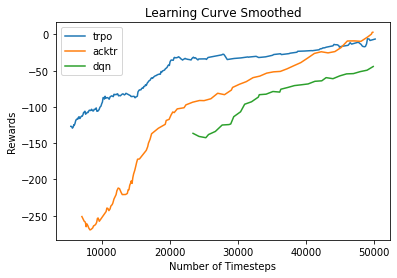

In [25]:
plot_results(log_folder = ["/tmp/gym/tpro","/tmp/gym/acktr",'/tmp/gym/dqn'], algorithms =['trpo','acktr','dqn'])